# Modeling (Using Variance Threshold)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import csv
import pickle

%matplotlib inline

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.linear_model import Ridge

np.random.seed(42)


## Load in clean training data

In [2]:
df = pd.read_csv('../datasets/aimes_clean_data', index_col='Id')

In [3]:
df.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_price
Id,,,,,,,,,,,,,,,,,,,,,
109,60,RL,<function <lambda> at 0x1c1b72ac80>,13517,Pave,None,IR1,Lvl,AllPub,CulDSac,...,0,0,None,None,None,0,3,2010,WD,130500
544,60,RL,43.0,11492,Pave,None,IR1,Lvl,AllPub,CulDSac,...,0,0,None,None,None,0,4,2009,WD,220000
153,20,RL,68.0,7922,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,1,2010,WD,109000
318,60,RL,73.0,9802,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,4,2010,WD,174000
255,50,RL,82.0,14235,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,3,2010,WD,138500


## Feature Selection

In this model I am one hot encoding categorical variables and using Variance Threshold to select my features.

## Get dummies

In [4]:
df_dummies = pd.get_dummies(df)

## Set up `X` and `y`

In [5]:
X = df_dummies.drop('sale_price', 1)
y = df_dummies.sale_price

In [6]:
df.shape

(2051, 78)

## Train Test Split

## Create training and validation sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

## Apply Variance Threshold to remove low variance features

In [8]:
threshold = VarianceThreshold(.05)

In [9]:
X_train_thresh = threshold.fit_transform(X_train)

In [10]:
X_test_thresh = threshold.transform(X_test)

In [11]:
X_train_thresh.shape ## not from Preprocessing Lecture

(1538, 129)

In [12]:
type(X_train_thresh) ## not from Preprocessing Lecture

numpy.ndarray

## Use  get_support method to get a boolean list of which columns from our X were included.

In [13]:
threshold.get_support()
included = X.columns[threshold.get_support()] #get the column names 

In [14]:
included

Index(['ms_subclass', 'lot_area', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod/add', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2',
       'bsmt_unf_sf',
       ...
       'garage_qual_None', 'garage_qual_TA', 'garage_cond_None',
       'garage_cond_TA', 'paved_drive_N', 'paved_drive_Y', 'fence_MnPrv',
       'fence_None', 'sale_type_New', 'sale_type_WD '],
      dtype='object', length=129)

## Align these columns with Kaggle Test Data

In [15]:
# # look at the difference between train and test columns
# set(included).difference(kaggle_with_dummies.columns)  #Code to run

In [16]:
not_included = X.columns[~threshold.get_support()]

In [17]:
not_included[:10]

Index(['kitchen_abvgr', 'ms_zoning_A (agr)', 'ms_zoning_C (all)',
       'ms_zoning_I (all)', 'ms_zoning_RH', 'lot_frontage_100.0',
       'lot_frontage_101.0', 'lot_frontage_102.0', 'lot_frontage_103.0',
       'lot_frontage_104.0'],
      dtype='object')

## Create column list for future alignment

In [18]:
columns = X.columns[threshold.get_support()]

## Scale the Data

In [19]:
ss = StandardScaler()

In [20]:
X_train_sc = ss.fit_transform(X_train_thresh)

In [21]:
X_test_sc = ss.transform(X_test_thresh)

## Export my data and scaler for use in future notebooks

In [22]:
with open('../datasets/X_train_sc.csv', 'w+') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerows(X_train_sc)

In [23]:
# do the same for X_test_sc

with open('../datasets/X_test_sc.csv', 'w+') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerows(X_test_sc)

In [24]:
y_train.to_csv('../datasets/y_train.csv', index=False, header=False)

In [25]:
# do the same for y_test
y_test.to_csv('../datasets/y_test.csv', index=False, header=False)

In [26]:
## Pickle the Scaler

with open('../assets/scaler.pkl', 'wb+') as f:
    pickle.dump(ss, f)

In [27]:
## I'll also save out my column labels to make sure that I can line up my data properly

with open('../assets/columns.pkl', 'wb+') as f:
    pickle.dump(list(included), f)

In [28]:
included

Index(['ms_subclass', 'lot_area', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod/add', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2',
       'bsmt_unf_sf',
       ...
       'garage_qual_None', 'garage_qual_TA', 'garage_cond_None',
       'garage_cond_TA', 'paved_drive_N', 'paved_drive_Y', 'fence_MnPrv',
       'fence_None', 'sale_type_New', 'sale_type_WD '],
      dtype='object', length=129)

## Linear Regression

In [29]:
lr = LinearRegression()
lr.fit(X_train_sc, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [30]:
lr.score(X_train_sc, y_train)

0.8864366204103126

In [31]:
lr.score(X_test_sc, y_test)

-9.187405944843323e+18

## Interpretation

The test score for linear regression is extremely low. This is a bad model that will not generalize well thus I cannot use it.

In [32]:
lr.intercept_

181062.0920472019

The intercept is about where would expect (the mean of y_train); however our coefficients are too large so I cannot use this model. 

In [33]:
lr.coef_

array([-1.16482926e+03,  3.48928654e+03,  1.45511691e+04,  5.05797274e+03,
        5.15501678e+03,  1.36623154e+03,  4.62778836e+03,  2.78888259e+15,
        1.01053473e+15,  2.63709427e+15, -2.70683712e+15,  5.14241124e+15,
        5.41547233e+15,  6.71833023e+14, -6.45274860e+15,  4.30592188e+03,
        2.46156250e+03, -7.01062500e+02,  3.21340625e+03,  2.19582812e+03,
        7.82875000e+03, -2.48625000e+02,  2.24768750e+03, -3.77906250e+02,
        1.15103125e+03,  1.40870312e+03,  5.40705469e+03, -4.10637500e+03,
       -6.66968750e+03,  2.87804688e+02, -3.97066895e+02,  1.84443750e+03,
        4.32512500e+03,  1.50140625e+03, -2.60625000e+02, -1.34087500e+03,
        7.27562500e+02,  1.14493750e+03, -3.86875000e+02,  4.45531250e+02,
        1.53453125e+03,  3.49518750e+03,  2.21687500e+03, -2.83618750e+03,
       -4.82062500e+03, -3.89817188e+03, -2.59846875e+03,  3.83370312e+03,
       -2.46643750e+03, -1.58795312e+03,  1.27481250e+03,  3.02857812e+03,
        5.17762500e+03, -

## Lasso

Instantiate our Model

In [34]:
lasso = LassoCV(n_alphas=100)

Fit Our Model

In [35]:
lasso.fit(X_train_sc, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

#### Lasso Train Score

In [36]:
lasso.score(X_train_sc, y_train)

0.8654132066692338

#### Lasso Test Score

In [37]:
lasso.score(X_test_sc,y_test)

0.9041661106478361

Our Model Scored higher on the Test Data than on the Train Data. This is likely due to chance and we should not use this model.

In [38]:
lasso_betas = pd.DataFrame(data=lasso.coef_,index=included,columns=['weights'])

In [39]:
lasso_betas['abs_w'] = lasso_betas.weights.abs()

In [40]:
lasso_betas.sort_values('abs_w', ascending=False, inplace=True)

Text(0.5, 1.0, 'Lasso Beta Weights\ny_intercept: 181061.99')

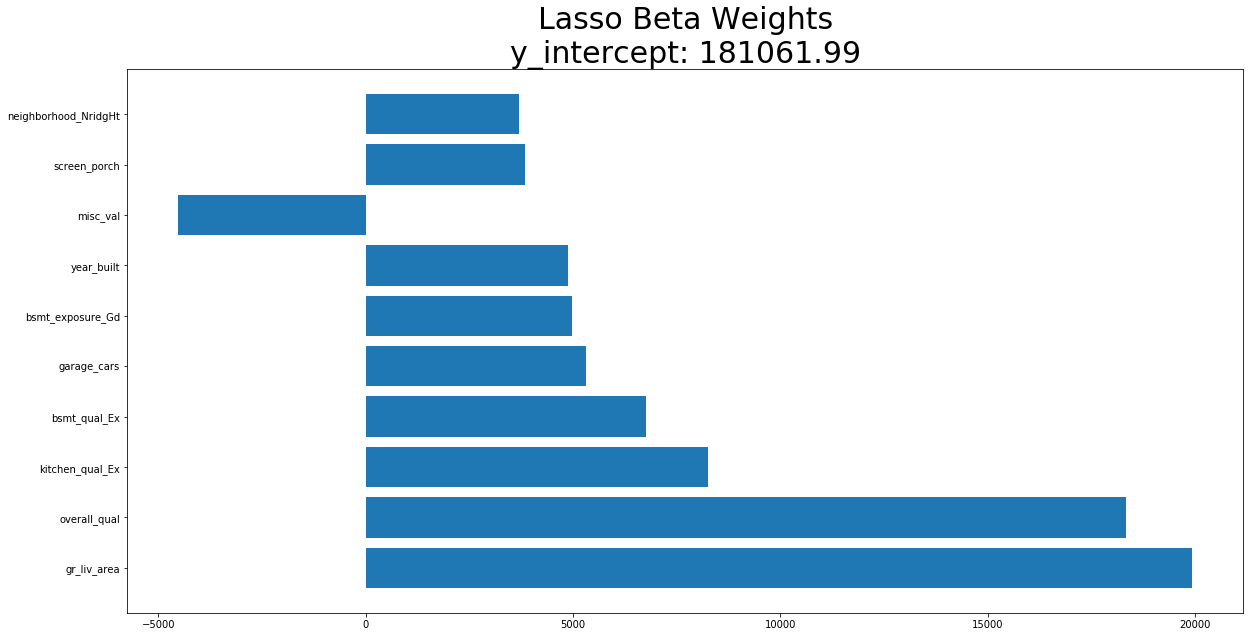

In [41]:
plt.figure(figsize= (20,10))
plt.barh(lasso_betas.head(10).index, lasso_betas['weights'].head(10))
plt.title(f'Lasso Beta Weights\ny_intercept: {lasso.intercept_:.2f}', size=30)

## Interpretation of Coefficients

My model shows that a one unit change in standard deviation for "Overall Quality" (holding all other coefficients constant) will lead to a change in price of $17,500. Increasing gr_liv_area square feet by one will increase the home price by $20,000. That said, I would like to test another model. 

Our y-intercept is around where we might expect it (the mean of y_train). We can interpret our intercept by saying: if all of our coefficients go to 0 then the price of our home would be $181,061.

## Ridge

#### Instantiate Our Model

In [42]:
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

#### Fit Our Model

In [43]:
ridge.fit(X_train_sc, y_train)

RidgeCV(alphas=array([ 0.1,  0.2, ...,  9.9, 10. ]), cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [44]:
# plt.title('SAT Section Scores', fontsize=20)
# plt.xticks();
# pd.Series(lasso.coef_).plot.bar(figsize=(15, 7))

#### Ridge Train Score

In [45]:
ridge.score(X_train_sc, y_train)

0.8863149180222465

#### Ridge Test Score

In [46]:
ridge.score(X_test_sc, y_test)

0.9024533368018518

Our Ridge Test Score is higher than our Ridge Training Score which again can just be due to chance. However, because the difference in R^2 is small we can save our model and run against our unseen test data.

In [47]:
ridge_betas = pd.DataFrame(data=ridge.coef_,index=included,columns=['weights'])

In [48]:
ridge_betas['abs_w'] = ridge_betas.weights.abs()

In [49]:
ridge_betas.sort_values('abs_w', ascending=False, inplace=True)

Text(0.5, 1.0, 'Ridge Beta Weights\ny_intercept: 181061.99')

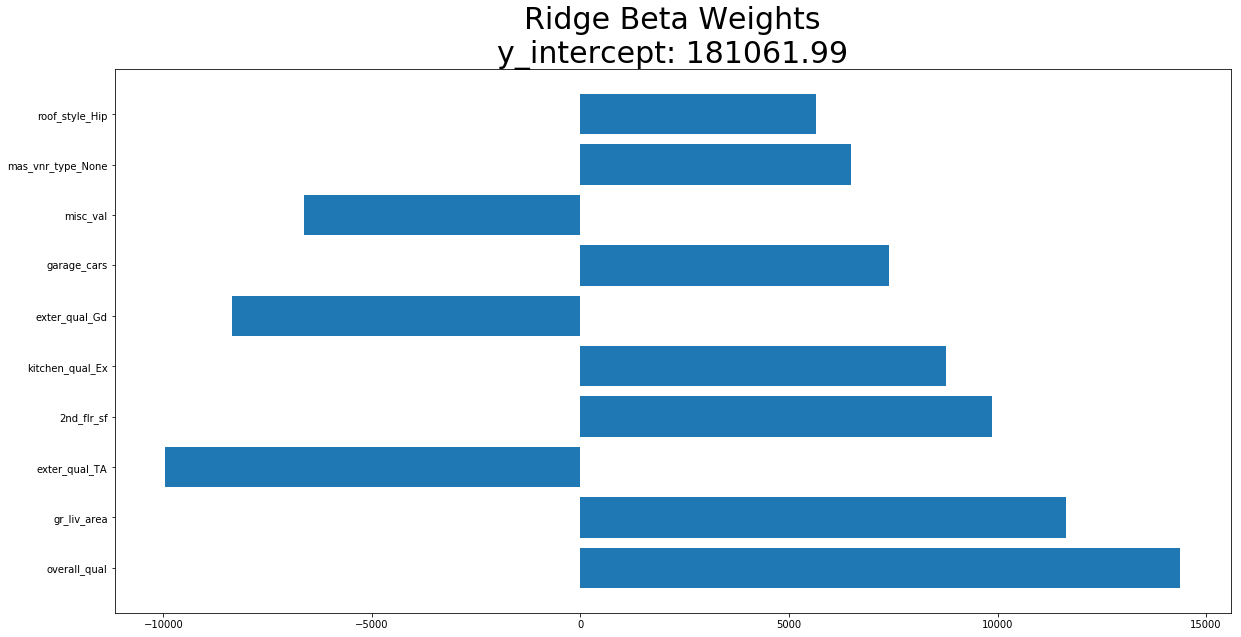

In [50]:
plt.figure(figsize= (20,10))
plt.barh(ridge_betas.head(10).index, ridge_betas['weights'].head(10))
plt.title(f'Ridge Beta Weights\ny_intercept: {ridge.intercept_:.2f}', size=30)

## Interpretation of Coefficients

Overall Quality, 2nd Floor Square Feet, and Above Ground Living Area (gr_liv_area) have some of the largest coefficients. This can be interpreted as a one unit increaes in Overall Quality (ex: Good to Very Good) will result in an increase in home value of 14,000 dollars. Increasing the gr_liv_area by one square foot will increase the home price by 12,000 dollars. And so on.

In [60]:
from sklearn.metrics import mean_squared_error

In [58]:
y_hat  = ridge.predict(X_test_sc)

In [62]:
mean_squared_error(y_test, y_hat)

598938924.3959397

In [63]:
mse  = np.mean(mean_squared_error(y_test, y_hat))
rmse = np.sqrt(mse)
rmse

24473.228728468577

Text(0.5, 1.0, 'RMSE')

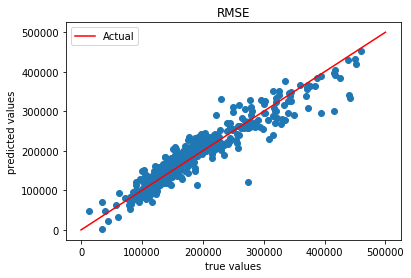

In [64]:
plt.scatter(y_test,ridge.predict(X_test_sc))
plt.ylabel('predicted values')
plt.xlabel('true values')
plt.plot([0, 500000], [0, 500000], color='r')
plt.legend(['Actual'])
plt.title('RMSE')

My model has an RMSE of 24,473 dollars which means that my predictions have an error + or - that value. My model predicts well for home values between the range of 100,000 and 250,000 dollars and then predicts worse as the true values get larger.

## Pickle My Model

In [51]:
with open('../assets/ridge.pkl', 'wb+') as f:
    pickle.dump(ridge, f)